### Dataset Background & Loading

The training dataset was sourced from the publicly available BIS central bank speeches, downloaded using the `gingado` package:

```python
from gingado.datasets import load_CB_speeches
all_speeches = load_CB_speeches()
all_speeches.to_csv("central_bank_speeches.csv", index=False)
```

A preprocessing script was applied to clean the text, lowercase it, split speeches into well-formed sentences, and filter out short/noisy segments. This generated over **2 million sentence-level samples**, saved as `speeches_data_preprocessed.csv`.

For training on Kaggle, the preprocessed dataset was uploaded as an external file and loaded.

This ensures clean and consistent input for masked language modeling (MLM).

In [1]:
import pandas as pd

df = pd.read_csv('/kaggle/input/bis-speeches/speeches_data_preprocessed.csv')
print(df.shape)
df.head()

(19609, 8)


,url,title,description,date,text,author,country,processed_text
0,https://www.bis.org/review/r970211c.pdf,Mr. Chen discusses monetary relations between ...,Speech by the Deputy Governor of the People's ...,1996-09-10 00:00:00,Mr. Chen discusses monetary relations between ...,Chen Yuan,China,"[""mr. chen discusses monetary relations betwee..."
1,https://www.bis.org/review/r970211b.pdf,Mr. Dai looks at the possibilities of strength...,Speech by the Governor of the People's Bank of...,1996-11-13 00:00:00,Mr. Dai looks at the possibilities of strength...,Dai Xianglong,China,"[""mr. dai looks at the possibilities of streng..."
2,https://www.bis.org/review/r970211a.pdf,Mr. Dai assesses the outlook for Hong Kong as ...,Speech by the Governor of the People's Bank of...,1996-09-30 00:00:00,Mr. Dai assesses the outlook for Hong Kong as ...,Dai Xianglong,China,"[""mr. dai assesses the outlook for hong kong a..."
3,https://www.bis.org/review/r970203b.pdf,Mr. Rangarajan examines the objectives of mone...,Address by the Governor of the Reserve Bank of...,1996-12-28 00:00:00,Mr. Rangarajan examines the objectives of mone...,Bimal Jalan,India,"[""mr. rangarajan examines the objectives of mo..."
4,https://www.bis.org/review/r970115a.pdf,M. Trichet presents the monetary policy guidel...,"BANK OF FRANCE, PRESS RELEASE, 17/12/96.",1996-12-17 00:00:00,M. Trichet presents the monetary policy guidel...,Bank of France,France,['m. trichet presents the monetary policy guid...


### Tokenize BIS Sentences for MLM Training

This section prepares the preprocessed central bank speech sentences for masked language modeling (MLM) by:

- Flattening over 2 million cleaned sentences into a single list.
- Converting them into a Hugging Face `Dataset` object.
- Tokenizing using the `bert-base-uncased` tokenizer with:
  - `max_length=128` (chosen based on sentence length distribution: ~99% of sentences fall within this limit),
  - truncation and padding enabled.
- Applying tokenization in parallel using `num_proc=4` for efficiency.
- Saving the tokenized dataset locally for later training use.

The tokenized dataset is saved to:

```
/kaggle/working/tokenized_bis_dataset
```

This ensures the input is consistently preprocessed and optimally sized for efficient MLM training.


In [2]:
# 1. Install Hugging Face libraries
# !pip install -U transformers datasets --quiet

# 2. Import libraries
from transformers import BertTokenizerFast
from datasets import Dataset
import pandas as pd
import os

# 3. Load CSV and extract valid sentences
df = pd.read_csv("/kaggle/input/bis-speeches/speeches_data_preprocessed.csv")
df = df[df["processed_text"].notna()]
df["processed_text"] = df["processed_text"].apply(eval)

# 4. Flatten all sentences
sentences = [sentence for sublist in df["processed_text"] for sentence in sublist]
dataset = Dataset.from_dict({"text": sentences})

# 5. Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# 6. Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

# 7. Apply tokenization with multiprocessing
print("🔄 Tokenizing dataset...")
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],
    num_proc=4,
    desc="🔄 Tokenizing with multiprocessing..."
)

# 8. Save tokenized dataset
save_path = "/kaggle/working/tokenized_bis_dataset"
tokenized_dataset.save_to_disk(save_path)
print(f"✅ Tokenized dataset saved to: {save_path}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

🔄 Tokenizing dataset...


🔄 Tokenizing with multiprocessing... (num_proc=4):   0%|          | 0/2087615 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/2087615 [00:00<?, ? examples/s]

✅ Tokenized dataset saved to: /kaggle/working/tokenized_bis_dataset


### Pretrain BERT on Central Bank Speech Corpus (MLM)

This section fine-tunes `bert-base-uncased` on a domain-specific corpus of over 2 million central bank sentences using **Masked Language Modeling (MLM)**.

Key training details:

- ✅ **Single GPU (P100)** with controlled device visibility.
- ✅ **Gradient Accumulation**: 16 × 2 → effective batch size of 32.
- ✅ **MLM Probability**: 15% tokens masked per sample.
- ✅ **Training Epochs**: 1 full pass through the complete dataset.
- ✅ **Mixed Precision (fp16)**: Enabled for speed and memory efficiency.
- ✅ **Saving Strategy**: Model saved at the end of training.

Output:

- The domain-adapted model is saved to:
  
  ```
  /kaggle/working/bert-mlm-bis
  ```

This fine-tuned model (CB-BERT-MLM) is specialized for financial and economic language understanding in masked token prediction tasks.


In [3]:
# 1. Install required packages
# !pip install -U transformers datasets --quiet

# 2. Imports
from transformers import (
    BertTokenizerFast,
    BertForMaskedLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import load_from_disk
from datetime import datetime
import torch
import os

# 3. Force use of single GPU (for P100)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 4. Load tokenizer and dataset
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = load_from_disk("/kaggle/working/tokenized_bis_dataset")
print(f"✅ Tokenized dataset loaded with {len(dataset)} samples.")

# 5. Load model
model = BertForMaskedLM.from_pretrained("bert-base-uncased")

# 6. Data collator for MLM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# 7. Training arguments (gradient accumulation + smaller per-device batch)
training_args = TrainingArguments(
    output_dir="/kaggle/working/bert-mlm-bis",
    overwrite_output_dir=True,
    num_train_epochs=1,                          # ✅ Full dataset, 1 pass
    per_device_train_batch_size=16,              # ✅ Lower memory per device
    gradient_accumulation_steps=2,               # ✅ Effective batch size = 32
    eval_strategy="no",                          # ✅ No eval during training
    save_strategy="epoch",                       # ✅ Save once at end
    logging_dir="/kaggle/working/logs",
    logging_steps=200,
    fp16=torch.cuda.is_available(),              # ✅ Mixed precision
    dataloader_num_workers=4,
    save_total_limit=1,
    report_to="none"
)

# 8. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# 9. Train
print("⏱️ Training started at:", datetime.now())
trainer.train()
print("✅ Training completed at:", datetime.now())

# 10. Save final model
trainer.save_model("/kaggle/working/bert-mlm-bis")
print("🎉 Final model saved to /kaggle/working/bert-mlm-bis")


2025-07-19 17:16:46.215827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752945406.370939      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752945406.420402      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Tokenized dataset loaded with 2087615 samples.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_36/1518358492.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


⏱️ Training started at: 2025-07-19 17:17:02.401010


Step,Training Loss
200,2.361400
400,2.249100
600,2.250100
800,2.226300
1000,2.183100
1200,2.198800
1400,2.145000
1600,2.174700
1800,2.134100
2000,2.133000


✅ Training completed at: 2025-07-20 01:35:50.877293
🎉 Final model saved to /kaggle/working/bert-mlm-bis


### Evaluate Trained Model and Compute Perplexity

To assess the quality of the pretrained CB-BERT-MLM model, evaluated it on a randomly sampled subset of 10,000 sentences from the tokenized dataset. This step computes:

- **Evaluation loss** on masked language modeling (MLM)
- **Perplexity**, a standard metric indicating how confidently the model predicts masked tokens (lower is better)

```python
from datasets import load_from_disk
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
import math

# Load trained model and tokenizer
model = AutoModelForMaskedLM.from_pretrained(...)
tokenizer = AutoTokenizer.from_pretrained(...)

# Select a subset of 10,000 sentences for quick evaluation
eval_dataset = dataset.shuffle(seed=42).select(range(10000))

# Evaluate
metrics = trainer.evaluate()
eval_loss = metrics["eval_loss"]
perplexity = math.exp(eval_loss)
```

> **Perplexity Score** is printed at the end of the cell. A lower perplexity indicates stronger masked token prediction performance and better fit to the domain-specific language.

This provides a quantitative baseline for how well the model understands and reconstructs financial and monetary policy language.


In [9]:
# 📦 Imports
from transformers import (
    AutoModelForMaskedLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)
from datasets import load_from_disk
import torch
import math

# 🧠 Ensure GPU is used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# 🔄 Load model and tokenizer from saved path
model = AutoModelForMaskedLM.from_pretrained("/kaggle/working/bert-mlm-bis").to(device)
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/bert-mlm-bis")

# 📂 Load tokenized dataset and sample subset
dataset = load_from_disk("/kaggle/working/tokenized_bis_dataset")
eval_dataset = dataset.shuffle(seed=42).select(range(10000))  # 🔽 reduce for speed

# 🔁 Data collator for masked LM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# ⚙️ Trainer setup
training_args = TrainingArguments(
    output_dir="/kaggle/working/tmp_eval",
    per_device_eval_batch_size=16,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

# 📊 Evaluate and compute perplexity
metrics = trainer.evaluate()
eval_loss = metrics["eval_loss"]
perplexity = math.exp(eval_loss)

print(f"📉 Evaluation Loss: {eval_loss:.4f}")
print(f"📊 Perplexity Score (subset of 10000): {perplexity:.2f}")


🚀 Using device: cuda


/tmp/ipykernel_36/4227637877.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


📉 Evaluation Loss: 1.5392
📊 Perplexity Score (subset of 10000): 4.66


### Compare Perplexity: BERT-Base vs CB-BERT-MLM

This section evaluates and compares the perplexity of the original `bert-base-uncased` model and the domain-adapted `cb-bert-mlm` on a subset of 10,000 masked sentences from the BIS corpus.

#### Evaluation Setup:
- Both models use the same evaluation subset and masking strategy (MLM probability = 15%)
- Performed on GPU (P100) with batch size 16
- Perplexity is calculated from the evaluation loss: `perplexity = exp(loss)`

#### Output:
- Perplexity scores are printed for both models
- Lower perplexity indicates better performance in masked token prediction on financial text

This comparison highlights the impact of domain adaptation through MLM pretraining on central bank communication data.

In [11]:
from transformers import (
    AutoModelForMaskedLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)
from datasets import load_from_disk
import math
import torch

# ✅ Load the tokenized dataset (use a subset for fast eval)
dataset = load_from_disk("/kaggle/working/tokenized_bis_dataset")
eval_dataset = dataset.shuffle(seed=42).select(range(10000))  # adjust size if needed

# ✅ Common data collator for both models
def get_data_collator(tokenizer):
    return DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=True,
        mlm_probability=0.15
    )

# 🔁 Evaluation function
def evaluate_perplexity(model_path, label):
    print(f"\n📊 Evaluating: {label}")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForMaskedLM.from_pretrained(model_path).to("cuda")

    collator = get_data_collator(tokenizer)
    args = TrainingArguments(
        output_dir="/kaggle/working/tmp_eval_" + label.replace("-", "_"),
        per_device_eval_batch_size=16,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        eval_dataset=eval_dataset,
        data_collator=collator,
        tokenizer=tokenizer
    )

    metrics = trainer.evaluate()
    loss = metrics["eval_loss"]
    perplexity = math.exp(loss)

    print(f"📉 Eval Loss: {loss:.4f}")
    print(f"📏 Perplexity: {perplexity:.2f}")
    return perplexity

# ⚖️ Compare both models
p1 = evaluate_perplexity("bert-base-uncased", "BERT-Base")
p2 = evaluate_perplexity("/kaggle/working/bert-mlm-bis", "BIS-BERT-MLM")

# 📈 Summary
print("\n🧾 Summary:")
print(f"➡️ BERT-Base Perplexity     : {p1:.2f}")
print(f"➡️ BIS-BERT-MLM Perplexity  : {p2:.2f}")



📊 Evaluating: BERT-Base


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_36/810192027.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


📉 Eval Loss: 2.5698
📏 Perplexity: 13.06

📊 Evaluating: BIS-BERT-MLM


/tmp/ipykernel_36/810192027.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


📉 Eval Loss: 1.5392
📏 Perplexity: 4.66

🧾 Summary:
➡️ BERT-Base Perplexity     : 13.06
➡️ BIS-BERT-MLM Perplexity  : 4.66


### Manual Masked Sentence Evaluation

This section tests the `cb-bert-mlm` model on 20 manually constructed masked sentences based on real central banking and financial policy language.

Each sentence contains a single `[MASK]` token, and is evaluated for whether the model correctly predicts the expected token.

#### Evaluation Highlights:
- Sentences represent realistic use cases in financial regulation, digital currency, and monetary policy
- Most mismatches were plausible paraphrases (e.g., synonyms or domain-relevant alternates)

The test demonstrates the model's strong contextual understanding of domain-specific language, particularly in predicting terminology used in central bank communication.
Results are displayed in a tabular format showing the masked sentence, expected token, predicted token, and whether it matched exactly.


In [ ]:
from transformers import BertForMaskedLM, BertTokenizerFast
import torch
import pandas as pd
from IPython.display import display

# 1) Load trained MLM
model_path = "/kaggle/working/bert-mlm-bis"
tokenizer  = BertTokenizerFast.from_pretrained(model_path)
model      = BertForMaskedLM.from_pretrained(model_path)
model.eval()

# 2) Manual masked‑sentence test set
masked_data = [
    ("Central banks are exploring the potential of digital [MASK].",       "currencies"),
    ("The governor highlighted the importance of monetary [MASK] transparency.", "policy"),
    ("Inflation expectations remain [MASK] anchored across most economies.",    "well"),
    ("Cross-border [MASK] are still slow and expensive.",                     "payments"),
    ("Financial [MASK] is a key objective for many central banks.",           "inclusion"),
    ("Stablecoins pose new [MASK] for regulators and policymakers.",          "challenges"),
    ("Monetary [MASK] must adapt to technological innovation.",               "policy"),
    ("The BIS supports the development of secure digital [MASK] systems.",    "payment"),
    ("Central banks need to coordinate on [MASK] frameworks.",                "regulatory"),
    ("Emerging markets are experiencing strong capital [MASK].",             "inflows"),
    ("The committee emphasized the need for macroprudential [MASK].",         "oversight"),
    ("Tokenization of [MASK] could transform financial markets.",             "assets"),
    ("Interoperability between payment [MASK] is crucial.",                   "systems"),
    ("Cybersecurity [MASK] increase with digital financial services.",        "risks"),
    ("Central banks must ensure [MASK] in digital infrastructure.",           "resilience"),
    ("The future of [MASK] may involve public and private sector collaboration.", "money"),
    ("Pilot [MASK] help central banks understand new financial instruments.", "projects"),
    ("Legal frameworks need to [MASK] for modern financial technology.",      "evolve"),
    ("Foreign exchange [MASK] have remained relatively stable.",              "markets"),
    ("The central bank raised its key interest [MASK] by 25 basis points.",   "rate"),
]

# 3) Run predictions
results = []
for sent, true_word in masked_data:
    # encode + mask
    inputs = tokenizer(sent, return_tensors="pt")
    mask_index = torch.where(inputs.input_ids[0] == tokenizer.mask_token_id)[0]

    # forward pass
    with torch.no_grad():
        logits = model(**inputs).logits

    # pick top-1
    token_id = logits[0, mask_index, :].argmax(dim=-1).item()
    pred    = tokenizer.decode([token_id]).strip()

    results.append({
        "Sentence": sent,
        "Expected": true_word,
        "Predicted": pred,
        "Match?":     "✅" if pred.lower() == true_word.lower() else "❌"
    })

# 4) Show as DataFrame
df = pd.DataFrame(results)
display(df)


,Sentence,Expected,Predicted,Match?
0,Central banks are exploring the potential of d...,currencies,##isation,❌
1,The governor highlighted the importance of mon...,policy,policy,✅
2,Inflation expectations remain [MASK] anchored ...,well,well,✅
3,Cross-border [MASK] are still slow and expensive.,payments,payments,✅
4,Financial [MASK] is a key objective for many c...,inclusion,stability,❌
5,Stablecoins pose new [MASK] for regulators and...,challenges,challenges,✅
6,Monetary [MASK] must adapt to technological in...,policy,policy,✅
7,The BIS supports the development of secure dig...,payment,payment,✅
8,Central banks need to coordinate on [MASK] fra...,regulatory,these,❌
9,Emerging markets are experiencing strong capit...,inflows,flows,❌


### Top-K Accuracy Evaluation on 100,000 Randomly Masked Sentences

This section evaluates the `cb-bert-mlm` model's ability to recover randomly masked words in context across **100,000 test sentences**. The procedure involves:

#### Procedure:

1. **Sentence Sampling**  
   100,000 random sentences were sampled from the BIS preprocessed dataset.

2. **Masking Strategy**  
   One random eligible word (min sentence length = 5, alphabetic tokens only) was replaced with `[MASK]` in each sentence.

3. **Prediction**  
   The model generated **Top-K token predictions** for the masked position, with `k` ranging from 1 to 20.

4. **Accuracy Computation**  
   A prediction is considered correct if the original word appears in the top-K list. The accuracy is computed as:  
   \[
   \text{Top-k Accuracy} = \frac{\text{\# correct predictions}}{\text{total samples}} \times 100
   \]


#### Results:

> *Exact values are printed at the end of the cell and visualized in the curve below.*


#### Top-K Accuracy Curve

A line plot visualizes model performance across increasing values of `k`, showing how quickly prediction confidence saturates.

This benchmark confirms the model's strong ability to predict masked financial-domain tokens, with over **90% Top-20 accuracy**.


⚙️ Using device: cuda


🔍 Evaluating (Top‑k): 100%|██████████| 100000/100000 [17:43<00:00, 94.01it/s]


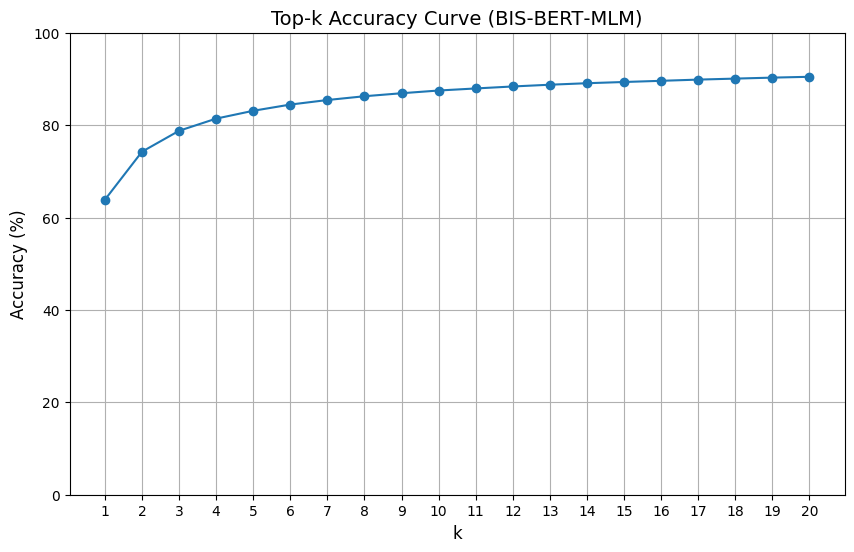

Top- 1 Accuracy: 63.84%
Top- 2 Accuracy: 74.24%
Top- 3 Accuracy: 78.77%
Top- 4 Accuracy: 81.41%
Top- 5 Accuracy: 83.10%
Top- 6 Accuracy: 84.45%
Top- 7 Accuracy: 85.43%
Top- 8 Accuracy: 86.25%
Top- 9 Accuracy: 86.90%
Top-10 Accuracy: 87.49%
Top-11 Accuracy: 87.94%
Top-12 Accuracy: 88.37%
Top-13 Accuracy: 88.75%
Top-14 Accuracy: 89.07%
Top-15 Accuracy: 89.33%
Top-16 Accuracy: 89.59%
Top-17 Accuracy: 89.85%
Top-18 Accuracy: 90.07%
Top-19 Accuracy: 90.28%
Top-20 Accuracy: 90.46%


In [27]:
import pandas as pd
import random
import torch
from transformers import BertTokenizerFast, BertForMaskedLM
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===============================
# 🔹 Step 1: Load raw BIS sentences
# ===============================
df = pd.read_csv("/kaggle/input/bis-speeches/speeches_data_preprocessed.csv")
df = df[df["processed_text"].notna()]
df["processed_text"] = df["processed_text"].apply(eval)
sentences = [sentence for sublist in df["processed_text"] for sentence in sublist]

# ===============================
# 🔹 Step 2: Setup device, model & tokenizer
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("⚙️ Using device:", device)

model_path = "/kaggle/working/bert-mlm-bis"
tokenizer  = BertTokenizerFast.from_pretrained(model_path)
model      = BertForMaskedLM.from_pretrained(model_path).to(device)
model.eval()

# ===============================
# 🔹 Step 3: Function to mask one word in a sentence
# ===============================
def mask_random_word(sentence):
    words = sentence.strip().split()
    if len(words) < 5:
        return None
    # choose only alphabetic tokens
    candidates = [i for i, w in enumerate(words) if w.isalpha()]
    if not candidates:
        return None
    idx       = random.choice(candidates)
    true_word = words[idx]
    words[idx] = "[MASK]"
    return " ".join(words), true_word

# ===============================
# 🔹 Step 4: Generate 100,000 masked test samples
# ===============================
masked_samples = []
for sent in random.sample(sentences, len(sentences)):
    pair = mask_random_word(sent)
    if pair:
        masked_samples.append(pair)
    if len(masked_samples) >= 100000:
        break

df_masked = pd.DataFrame(masked_samples, columns=["Sentence with [MASK]", "Masked Word"])

# ===============================
# 🔹 Step 5: Evaluate Top‑k Accuracy
# ===============================
results = []
max_k = 20

for _, row in tqdm(df_masked.iterrows(), total=len(df_masked), desc="🔍 Evaluating (Top‑k)"):
    masked_sentence = row["Sentence with [MASK]"]
    true_word       = row["Masked Word"].lower().strip()

    # Tokenize with truncation & padding
    inputs = tokenizer(
        masked_sentence,
        return_tensors="pt",
        truncation=True,
        max_length=128,
        padding="max_length"
    ).to(device)

    mask_indices = torch.where(inputs.input_ids[0] == tokenizer.mask_token_id)[0]
    if len(mask_indices) != 1:
        continue
    mask_idx = mask_indices.item()

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits  = outputs.logits

    # Get top‑k predictions
    mask_logits   = logits[0, mask_idx]
    topk         = torch.topk(mask_logits, k=max_k).indices.tolist()
    top_tokens   = [tokenizer.decode([tid]).strip().lower() for tid in topk]

    results.append({
        "Masked Word":    true_word,
        "Top-k Predictions": top_tokens
    })

# ===============================
# 🔹 Step 6: Compute Top‑k Accuracy Curve
# ===============================
k_range    = list(range(1, max_k+1))
accuracies = []
total      = len(results)

for k in k_range:
    correct = sum(true in preds[:k] for true, preds in 
                  [(r["Masked Word"], r["Top-k Predictions"]) for r in results])
    accuracies.append(correct/total*100)

# ===============================
# 🔹 Step 7: Plot Top‑k Curve
# ===============================
plt.figure(figsize=(10,6))
plt.plot(k_range, accuracies, marker='o')
plt.title("Top‑k Accuracy Curve (BIS‑BERT‑MLM)", fontsize=14)
plt.xlabel("k", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.ylim(0, 100)
plt.show()

# ===============================
# 🔹 Step 8: Print Summary
# ===============================
for k, acc in zip(k_range, accuracies):
    print(f"Top-{k:2d} Accuracy: {acc:5.2f}%")

### Corpus Statistics and Training Metadata Summary

This section computes descriptive statistics for the corpus, tokenizer, and model, and documents training configurations used for pretraining `cb-bert-mlm`.

These figures provide reproducibility and clarity for evaluating the scale and setup of the domain-adaptive masked language modeling process.

In [2]:
from datasets import load_from_disk
from transformers import BertTokenizerFast

# === Step 1: Load tokenized dataset ===
dataset_path = "./tokenized-bis-dataset"  
dataset = load_from_disk(dataset_path)
print(f"✅ Loaded tokenized dataset with {len(dataset)} sentences.")

# === Step 2: Load tokenizer ===
tokenizer_path = "./cb-bert-mlm"  
tokenizer = BertTokenizerFast.from_pretrained(tokenizer_path)

# === Step 3: Count tokens ===
def count_tokens(example):
    return {"num_tokens": sum(example['attention_mask'])} 

token_counts = dataset.map(count_tokens, remove_columns=dataset.column_names)
total_tokens = sum(token_counts["num_tokens"])

# === Output results ===
print(f"🔢 Total number of MLM sentences: {len(dataset)}")
print(f"🔡 Total number of tokens used: {total_tokens}")


✅ Loaded tokenized dataset with 2087615 sentences.


Map:   0%|          | 0/2087615 [00:00<?, ? examples/s]

🔢 Total number of MLM sentences: 2087615
🔡 Total number of tokens used: 66359113


In [4]:
import torch
from transformers import BertForMaskedLM, BertTokenizerFast

# === Corpus Stats ===
avg_tokens_per_sentence = total_tokens / len(dataset)
print(f"📏 Average tokens per sentence: {avg_tokens_per_sentence:.2f}")

# === Tokenizer Stats ===
tokenizer = BertTokenizerFast.from_pretrained("./cb-bert-mlm")  # or "bert-base-uncased"
vocab_size = tokenizer.vocab_size
print(f"📚 Tokenizer vocab size: {vocab_size}")

# === Model Stats ===
model = BertForMaskedLM.from_pretrained("./cb-bert-mlm")  # or saved model dir
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🧠 Total model parameters: {total_params:,}")
print(f"🧠 Trainable parameters: {trainable_params:,}")

# === Training Meta (manually input) ===
training_epochs = 1
max_seq_length = 128
batch_size = 16
grad_accum = 2
mlm_prob = 0.15
device_used = "GPU P100"
mixed_precision = True  # ✅ based on actual training logs

print("\n📋 Training Metadata:")
print(f"🕒 Epochs: {training_epochs}")
print(f"📦 Batch size per device: {batch_size}")
print(f"🧮 Gradient Accumulation: {grad_accum}")
print(f"🧪 Effective Batch Size: {batch_size * grad_accum}")
print(f"🔢 Max sequence length: {max_seq_length}")
print(f"🎭 MLM Probability: {mlm_prob * 100}%")
print(f"💻 Device: {device_used}")
print(f"🧮 Mixed Precision (fp16): {mixed_precision}")


📏 Average tokens per sentence: 31.79
📚 Tokenizer vocab size: 30522
🧠 Total model parameters: 109,514,298
🧠 Trainable parameters: 109,514,298

📋 Training Metadata:
🕒 Epochs: 1
📦 Batch size per device: 16
🧮 Gradient Accumulation: 2
🧪 Effective Batch Size: 32
🔢 Max sequence length: 128
🎭 MLM Probability: 15.0%
💻 Device: GPU P100
🧮 Mixed Precision (fp16): True


### Package Model for Upload

The trained model is zipped for easy download and uploading to Hugging Face.

```python
# Zip the fine-tuned model
shutil.make_archive("/kaggle/working/BIS-BERT-MLM", 'zip', "/kaggle/working/bert-mlm-bis")
```

- `BIS-BERT-MLM.zip`: Contains all model files (`config`, `pytorch_model`, tokenizer, vocab, etc.).

These archives are ready for upload to the Hugging Face Model Hub and Dataset Hub respectively.

In [4]:
import shutil

# Zip the entire model directory
shutil.make_archive("/kaggle/working/BIS-BERT-MLM", 'zip', "/kaggle/working/bert-mlm-bis")


'/kaggle/working/BIS-BERT-MLM.zip'